In [1]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

import seaborn as sns

In [2]:
from data_processing import SHARKDataProcessor
processor = SHARKDataProcessor()

# Define subvolume IDs and HDF5 file paths
sv_list = np.arange(64)
sharkfiles = [f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] #DEFINE FILE

# Output shark_csv dataframe
shark_csv = processor.process_all_subvolumes(sv_list, sharkfiles)
print(shark_csv.head())

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0   0_12323        0_1  0_199000000000184     0_1   0     0  1.553645e+12   
1   0_41884        0_2  0_199000000032613     0_1   0     1  1.553645e+12   
2   0_25337        0_4  0_199000000000239     0_2   0     0  1.013176e+12   
3   0_12324        0_4  0_199000000000239     0_2   0     2  1.013176e+12   
4  0_325815        0_5  0_199000000032723     0_2   0     1  1.013176e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  1.406334e+12  4.406725e+10  8.090279e+09  ...   0.239161  8.448190   
1  1.132662e+11  6.663850e+07  3.927870e+08  ...   0.000000  0.045958   
2  7.889350e+11  1.441911e+10  7.342129e+06  ...   5.469577  0.054259   
3  4.321138e+10  4.237961e+08  9.966004e+08  ...   0.000000  0.128186   
4  2.242409e+11  4.860634e+08  7.437644e+08  ...   0.000000  0.316807   

    SFR_all           MBH  MBHacc_cold    MBHacc_hot    MBHacc_all  \
0  8.687351  2.992633e+07   

In [3]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

########################################
# Late and Early Type Galaxies
########################################
valid_data = shark_csv['Mstar_all'] > 0

shark_csv_late = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] > 0.5) & valid_data  # Late-Type Galaxies (D/T > 0.5)
shark_csv_early = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] <= 0.5) & valid_data  # Early-Type Galaxies (D/T <= 0.5)

In [4]:
########## STELLAR VS HALO CSV (Lagos 2024)

file_path = "Shark v2.0.csv"

WPD = pd.read_csv(file_path, header=None)
WPD.columns = ["Column1", "Column2"]
WPD = 10 ** WPD

# Sort the dataframe by Column1 in ascending order
WPD = WPD.sort_values(by="Column1").reset_index(drop=True)

print('Lagos 2024: ',WPD.head())

########## STELLAR VS HALO CSV (Kravstov 2018, via Lagos 2024)

file_path = "Kravstov 18.csv"

k18 = pd.read_csv(file_path, header=None)
k18.columns = ["Column1", "Column2"]
k18 = 10 ** k18

print('Kravstov 2018: ',k18.head())

Lagos 2024:          Column1       Column2
0  3.333205e+10  2.885157e+07
1  3.624092e+10  3.448389e+07
2  4.072164e+10  4.342679e+07
3  4.575634e+10  5.456180e+07
4  5.141352e+10  6.855192e+07
Kravstov 2018:          Column1       Column2
0  6.045149e+11  9.051051e+09
1  8.190616e+11  1.460759e+10
2  1.189534e+12  2.214359e+10
3  1.712649e+12  3.499652e+10
4  2.620244e+12  5.530297e+10


xVals:  [1.27669972e+10 1.96415350e+10 3.01170186e+10 4.68123231e+10
 7.07095253e+10 1.02790694e+11 1.57132280e+11 2.40936149e+11
 3.67951416e+11 5.66003542e+11 8.68810587e+11 1.33496968e+12
 2.04664802e+12 3.13855350e+12 4.82559770e+12 7.38849078e+12
 1.14506891e+13 1.72334809e+13 2.67229601e+13 4.12216800e+13
 6.14816128e+13 9.27116449e+13 1.44134502e+14 2.33956177e+14
 3.41569455e+14 4.65393709e+14 7.56700703e+14]
bin_medians:  [1.53670856e+08 1.52011104e+08 1.60731699e+08 1.57287868e+08
 1.44856740e+08 2.57370475e+08 5.58202957e+08 1.25357293e+09
 2.95455059e+09 7.24462734e+09 1.50365713e+10 1.85388887e+10
 1.31045572e+10 5.52457990e+09 2.10693558e+09 1.39633244e+09
 1.01180198e+09 9.22642019e+08 8.50066882e+08 8.24995076e+08
 7.78537520e+08 7.63767903e+08 7.81065573e+08 7.55893775e+08
 7.42563712e+08 7.82751948e+08 7.11784533e+08]
928625


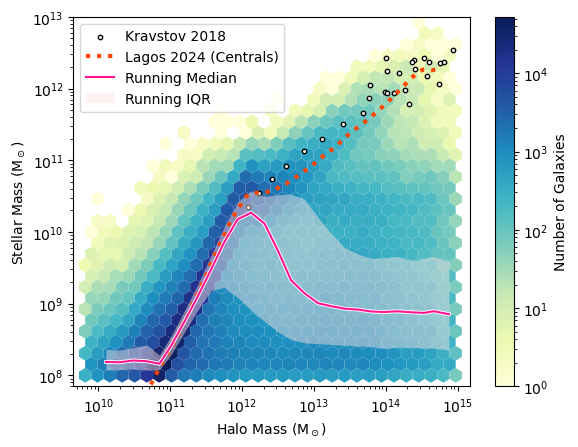

In [73]:
# Set a shared x and y-axis range
y_min = 7*10**7
y_max = 10**13
x_min = 4.5*10**9
x_max = 1.5*10**15

##############################
# BINNED MEDIANS
##############################
# Calculate min and max log values of Mhalo_host
lowLog = math.log10(shark_csv['Mhalo_host'].min())
highLog = math.log10(shark_csv['Mhalo_host'].max())

# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 27
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# MEDIAN for y-values
result = binned_statistic(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], statistic='median', bins=logBins)
bin_medians = result.statistic

# Calculate xVals by finding the median Mhalo_host value within each bin
xVals = []
for j in range(len(logBins) - 1):
    # Filter data points within the current bin
    bin_data = shark_csv['Mhalo_host'][(shark_csv['Mhalo_host'] >= logBins[j]) & (shark_csv['Mhalo_host'] < logBins[j+1])]
    if len(bin_data) > 0:
        # Append the median of Mhalo_host values in the bin to xVals
        xVals.append(np.median(bin_data))
    else:
        # If no data points in the bin, append NaN or skip
        xVals.append(np.nan)

# Convert xVals to a numpy array and remove NaN values (if necessary)
xVals = np.array(xVals)
valid_bins = ~np.isnan(xVals)
xVals = xVals[valid_bins]
bin_medians = bin_medians[valid_bins]

# PERCENTILES
# 25th percentile
percentile_25 = binned_statistic(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], statistic=lambda values: np.percentile(values, 25), bins=logBins)
p25 = percentile_25.statistic[valid_bins]
# 75th percentile
percentile_75 = binned_statistic(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], statistic=lambda values: np.percentile(values, 75), bins=logBins)
p75 = percentile_75.statistic[valid_bins]


print('xVals: ',xVals)
print('bin_medians: ',bin_medians)
#plt.plot(xVals, bin_medians, linewidth=1.5, color='deeppink')

#######################
# Plotting
#######################
hb = plt.hexbin(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], gridsize=30, xscale='log', yscale='log',
                reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='YlGnBu')
plt.scatter(k18["Column1"], k18["Column2"], color='white', label='Kravstov 2018', s=10, edgecolors='black')
plt.plot(WPD["Column1"], WPD["Column2"], color='orangered', label='Lagos 2024 (Centrals)', lw=3, ls='dotted')

plt.plot(xVals, bin_medians, linewidth=2.8, color='white')
plt.plot(xVals, bin_medians, linewidth=1.5, color='deeppink', label='Running Median')
plt.fill_between(xVals, p25, p75, color='mistyrose', alpha=0.45, label='Running IQR', linewidth=0)

cb = plt.colorbar(hb)
cb.set_label('Number of Galaxies')
plt.legend(loc='upper left')

plt.ylim([y_min, y_max])
plt.xlim([x_min, x_max])

plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel(r'Stellar Mass (M$_\odot$)')

print(len(shark_csv['Mhalo_host']))

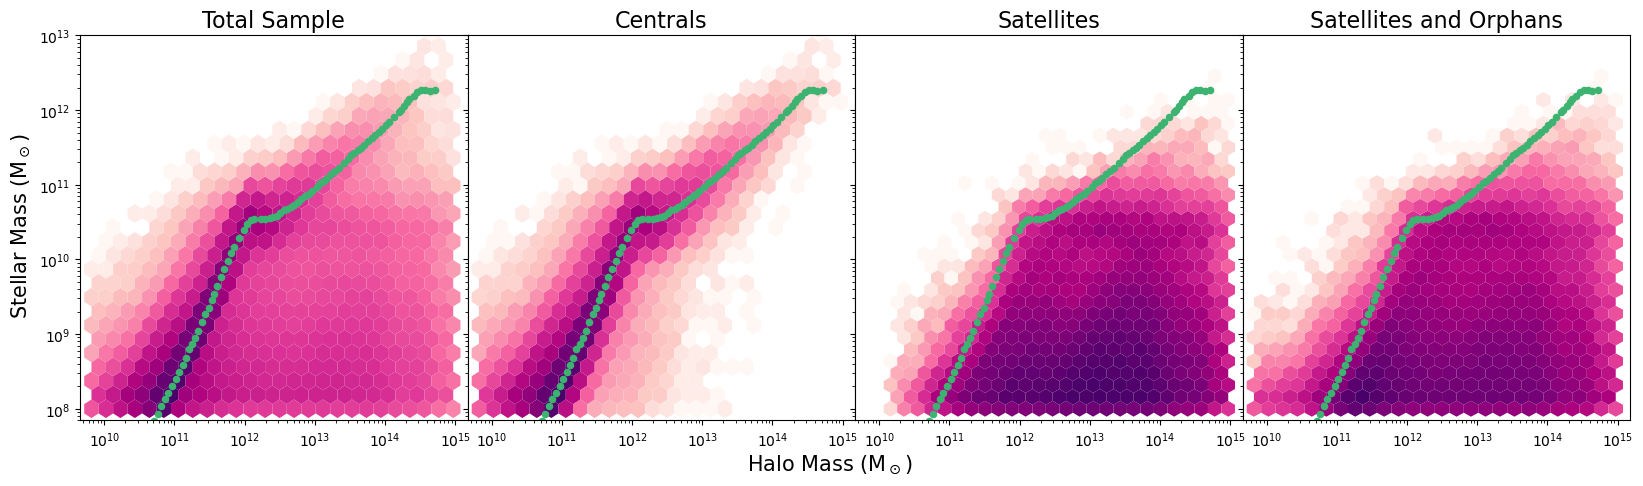

In [6]:
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 7*10**7
y_max = 10**13
x_min = 4.5*10**9
x_max = 1.5*10**15

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    hb = axs[i].hexbin(data['Mhalo_host'], data['Mstar_all'], gridsize=25, xscale='log', yscale='log',
                       reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='RdPu')
    axs[i].scatter(WPD["Column1"], WPD["Column2"], color='mediumseagreen', s=20, label='WPD Points')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, r'Stellar Mass (M$_\odot$)', va='center', rotation='vertical', fontsize=15)

plt.show()

Total Sample xVals:  [3.56821211e+10 1.05409574e+11 4.92347815e+11 2.77207534e+12
 1.57819697e+13 7.48408096e+13 3.51294922e+14]
Total Sample bin_medians:  [1.59830982e+08 2.77952552e+08 3.72508194e+09 6.52286732e+09
 9.48265866e+08 7.87387018e+08 7.39672045e+08]
Centrals xVals:  [3.56821211e+10 1.03118059e+11 4.59611899e+11 2.36369510e+12
 1.21371589e+13 5.85402849e+13 2.84535930e+14]
Centrals bin_medians:  [1.59623759e+08 2.85186186e+08 5.98979612e+09 3.66947196e+10
 1.16493129e+11 4.25946783e+11 1.66890288e+12]
Satellites xVals:  [3.92830669e+10 1.60733229e+11 7.14951843e+11 3.29994156e+12
 1.67467000e+13 7.58186211e+13 3.51294922e+14]
Satellites bin_medians:  [1.77551035e+08 2.10603460e+08 3.70819894e+08 4.61753539e+08
 5.27348766e+08 6.32738593e+08 6.72559745e+08]
Satellites and Orphans xVals:  [3.01170186e+10 1.69244560e+11 6.11506456e+11 3.13282505e+12
 1.63725287e+13 7.56287498e+13 3.51294922e+14]
Satellites and Orphans bin_medians:  [1.63025237e+08 1.82262523e+08 3.78865777e+0

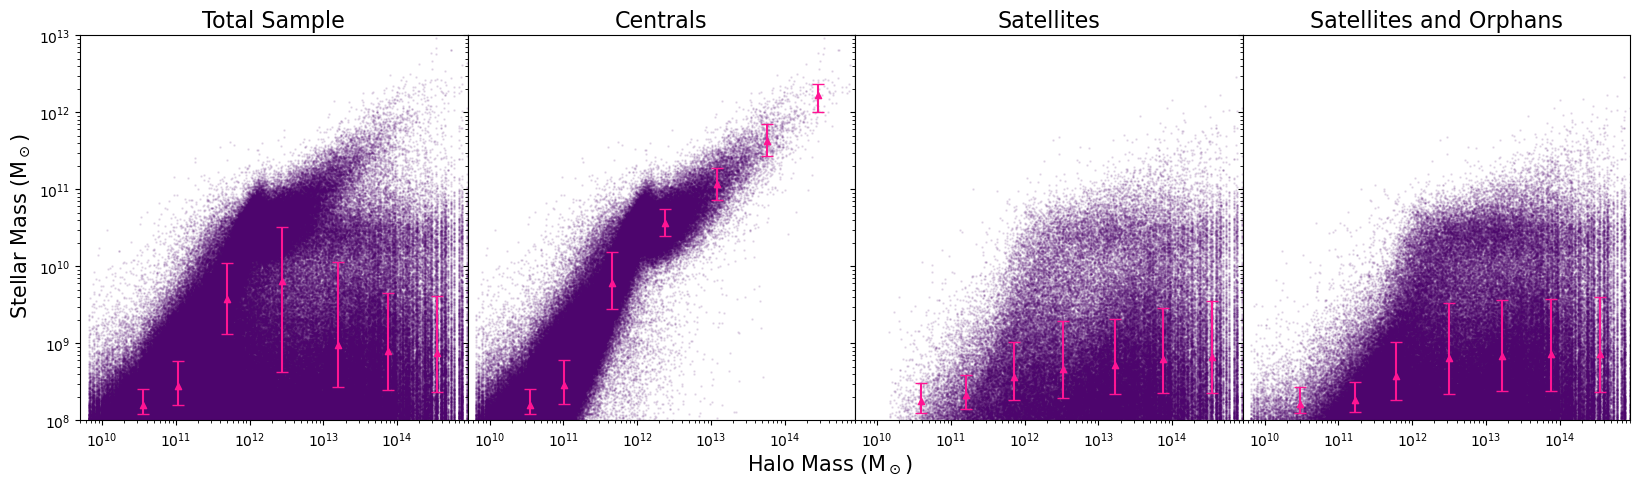

In [39]:
########################################
# Scatter Plots (Stellar vs Halo Mass)
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 10**8
y_max = 10**13
x_min = 5*10**9
x_max = 9*10**14

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mhalo_host'].min())
    highLog = math.log10(data['Mhalo_host'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 7
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mhalo_host'], data['Mstar_all'], statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mhalo_host'][(data['Mhalo_host'] >= logBins[j]) & (data['Mhalo_host'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    print(f'{title}','xVals: ',xVals)
    print(f'{title}','bin_medians: ',bin_medians)

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mhalo_host'], data['Mstar_all'], statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mhalo_host'], data['Mstar_all'], statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].scatter(data['Mhalo_host'], data['Mstar_all'], s=0.8, alpha=0.1, color='#4d056d')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

    # Bin plotting
    axs[i].scatter(xVals, bin_medians, s=20, color='deeppink', marker="^")
    axs[i].errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='deeppink', capsize=4)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Halo Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, r'Stellar Mass (M$_\odot$)', va='center', rotation='vertical', fontsize=15)

plt.show()